## Import Pythonic Libraries
This notebook should be run at [swan.cern.ch](swan.cern.ch).  The notebook parameters used are:
- Python 3
- Software stack: 97
- Platform: CentOS 7 (gcc9)
- Number of cores: 2 or 4
- Memory: 8 or 10 GB

Requires downloading `root` samples (within a directory) to the working directory hosting this notebook.

In [1]:
import os, sys
import numpy as np
from scipy import stats
import ROOT
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ROOT import TMVA, TFile, TTree, TCut, TRandom3
from ROOT import TCanvas, TGraph
from ROOT import gSystem, gApplication, gROOT

ROOT.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.20/02


## Select the samples and variables to compare

In [2]:
# get list of directories in working directory
dirList = next(os.walk(os.getcwd()))[1]

# root paths
treeName = "ljmet"

In [3]:
print("Choose the first sample directory for comparison:")
sampleDirOne = widgets.Dropdown( options = dirList )
sampleDirOne

Choose the first sample directory for comparison:


Dropdown(options=('.config', '.keras', '.local', '.pki', '.ssh', '.sys.v#.Array Example.ipynb', '.sys.v#.Centr…

In [4]:
print("Choose the sample from {}:".format( sampleDirOne.value ))
sampleOne = widgets.Dropdown( options = os.listdir( sampleDirOne.value ) )
sampleOne

Choose the sample from FWLJMET102X_1lep2017_Oct2019_4t_03202020_step2:


Dropdown(options=('TTTT_TuneCP5_PSweights_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_PSweights_13Te…

In [5]:
print("Choose the second sample directory for comparison:")
sampleDirTwo = widgets.Dropdown( options = dirList )
sampleDirTwo

Choose the second sample directory for comparison:


Dropdown(options=('.config', '.keras', '.local', '.pki', '.ssh', '.sys.v#.Array Example.ipynb', '.sys.v#.Centr…

In [6]:
print("Choose the sample from {}:".format( sampleDirTwo.value ))
sampleTwo = widgets.Dropdown( options = os.listdir( sampleDirTwo.value ) )
sampleTwo

Choose the sample from FWLJMET102X_1lep2018_Oct2019_4t_03302020_step2:


Dropdown(options=('TTTT_TuneCP5_13TeV-amcatnlo-pythia8_hadd.root',), value='TTTT_TuneCP5_13TeV-amcatnlo-pythia…

In [7]:
rootFileOne = ROOT.TFile.Open( sampleDirOne.value + "/" + sampleOne.value )
rootTreeOne = rootFileOne.Get( treeName )
branchListOne = [ branch.GetName() for branch in rootTreeOne.GetListOfBranches() ]
rootFileTwo = ROOT.TFile.Open( sampleDirTwo.value + "/" + sampleTwo.value )
rootTreeTwo = rootFileTwo.Get( treeName )
branchListTwo = [ branch.GetName() for branch in rootTreeTwo.GetListOfBranches() ]

commonBranches = set(branchListOne).intersection(branchListTwo)
print("{} out of {} variables shared.".format(
    len(commonBranches), len(branchListOne)
))

print("Choose the variable to compare:")
fileList = widgets.Dropdown( options = commonBranches )
fileList

382 out of 383 variables shared.
Choose the variable to compare:


Dropdown(options=('topPhi_HOTTaggerCalc', 'HOTBadTrijet3_dijetmass', 'theJetAK8MatchedPt_JetSubCalc_PtOrdered'…

In [81]:
# read in cut variables
cutOne = rootTreeOne.AsMatrix( [
    "leptonPt_MultiLepCalc",
    "isElectron",
    "isMuon",
    "corr_met_MultiLepCalc",
    "MT_lepMet",
    "minDR_lepJet",
    "AK4HT",
    "DataPastTriggerX",
    "MCPastTriggerX",
    "NJetsCSVwithSF_MultiLepCalc",
    "NJets_JetSubCalc"
] )
cutTwo = rootTreeTwo.AsMatrix( [
    "leptonPt_MultiLepCalc",
    "isElectron",
    "isMuon",
    "corr_met_MultiLepCalc",
    "MT_lepMet",
    "minDR_lepJet",
    "AK4HT",
    "DataPastTriggerX",
    "MCPastTriggerX",
    "NJetsCSVwithSF_MultiLepCalc",
    "NJets_JetSubCalc"
] )

In [82]:
# apply cuts
cutMaskOne = np.zeros(np.shape(cutOne)[0])
cutMaskTwo = np.zeros(np.shape(cutTwo)[0])
for i in range(np.shape(cutOne)[0]):
    if ( ( cutOne[i][0] > 50 and cutOne[i][1] == 1 ) or ( cutOne[i][0] > 50 and cutOne[i][2] == 1 ) ):
        if ( cutOne[i][3] > 60 and cutOne[i][4] > 60 and cutOne[i][5] > 0.4 and cutOne[i][6] > 510 ):
            if ( cutOne[i][7] == 1 and cutOne[i][8] == 1 ):
                if ( cutOne[i][9] >= 2 and cutOne[i][10] >= 6 ):
                    cutMaskOne[i] = 1
print("{} events passed for sample one...".format(np.sum(cutMaskOne)))
for i in range(np.shape(cutTwo)[0]):
    if ( ( cutTwo[i][0] > 50 and cutTwo[i][1] == 1 ) or ( cutTwo[i][0] > 50 and cutTwo[i][2] == 1 ) ):
        if ( cutTwo[i][3] > 60 and cutTwo[i][4] > 60 and cutTwo[i][5] > 0.4 and cutTwo[i][6] > 510 ):
            if ( cutTwo[i][7] == 1 and cutTwo[i][8] == 1 ):
                if ( cutTwo[i][9] >= 2 and cutTwo[i][10] >= 6 ):
                    cutMaskTwo[i] = 1
print("{} events passed for sample two...".format(np.sum(cutMaskTwo)))

101397.0 events passed for sample one...
110389.0 events passed for sample two...


In [83]:
# populate the branches
branchOne = np.asarray(rootTreeOne.AsMatrix( [ str(fileList.value) ]))
branchTwo = np.asarray(rootTreeTwo.AsMatrix( [ str(fileList.value) ]))
branchCutOne = branchOne.reshape(len(branchOne))[cutMaskOne.astype(bool)]
branchCutTwo = branchTwo.reshape(len(branchTwo))[cutMaskTwo.astype(bool)]

## Plot the two distributions
The (two sample) Kolmogorov-Smirnov test is used to evaluate if the two input distributions are sampled from the same parent population. Two metrics are provided: the Kolmogrov-Smirnov statistic ($D$) and the $p$-value.  $D$ represents a determinant which determines whether the null hypothesis of being similarly sampled is rejected,
$$D_{n,m}>c(\alpha)\sqrt{\frac{n+m}{n\times m}}$$
where $c(\alpha)$ is given by,
$$c(\alpha)=\sqrt{-\ln(\frac{\alpha}{2})\times \frac{1}{2}}$$
and $n$ and $m$ are the sizes of the respective distributions.

The $p$-value is evaluated by whether it is above or below the set $\alpha$.  That is, if $p>\alpha$, then the null hypothesis is not rejected.  Thus, either $D$ or $p$ can be used in evaluating the similarity of the distributions.

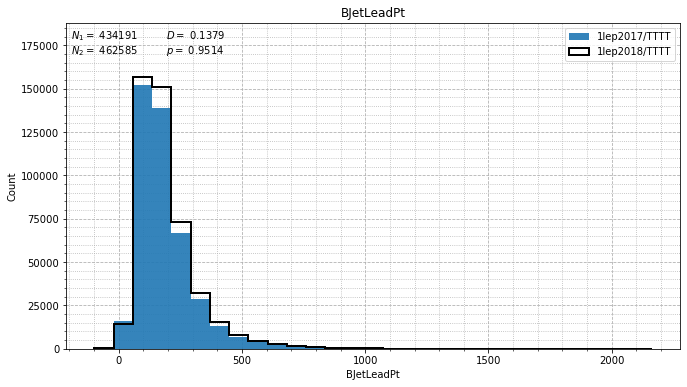

In [84]:
# set uniform binning
nBins = 30
minBin = min(min(branchOne),min(branchTwo))
maxBin = max(max(branchOne),max(branchTwo))
bins = np.linspace(minBin,maxBin,nBins).reshape(nBins)

# plot the histograms
plt.rc("axes", axisbelow = True)
plt.close()
plt.figure( figsize = (11, 6) )
plt.title( str(fileList.value) )
histOne, binsOne, _ = plt.hist(
    branchOne,
    label = sampleDirOne.value.split("_")[1] + "/" + sampleOne.value.split("_TuneCP5")[0],
    histtype = "stepfilled",
    linewidth = 2,
    alpha = 0.9,
    bins = bins
)
histTwo, binsTwo, _ = plt.hist(
    branchTwo,
    label = sampleDirTwo.value.split("_")[1] + "/" + sampleTwo.value.split("_TuneCP5")[0],
    histtype = "step",
    linewidth = 2,
    color = "k",
    alpha = 1.0,
    bins = bins
)

D, pVal = stats.ks_2samp(histOne, histTwo)

plt.annotate(
    u"$N_1=$ {}".format( len( branchOne ) ),
    xycoords = "axes pixels",
    xy = (5,310)
)
plt.annotate(
    u"$N_2=$ {}".format( len( branchTwo ) ),
    xycoords = "axes pixels",
    xy = (5,295)
)
plt.annotate(
    u"$D=$ {:.4f}".format( D ),
    xycoords = "axes pixels",
    xy = (100,310)
)
plt.annotate(
    u"$p=$ {:.4f}".format( pVal ),
    xycoords = "axes pixels",
    xy = (100, 295)
)

plt.xlabel( str(fileList.value) )
plt.ylabel( "Count" )
plt.ylim(0,1.2*max(max(histOne),(max(histTwo))))
#plt.yscale( "log" )
plt.legend( loc = "best" )
plt.grid( which = "major", linestyle = "--" )
plt.grid( which = "minor", linestyle = ":")
plt.minorticks_on()
plt.show()

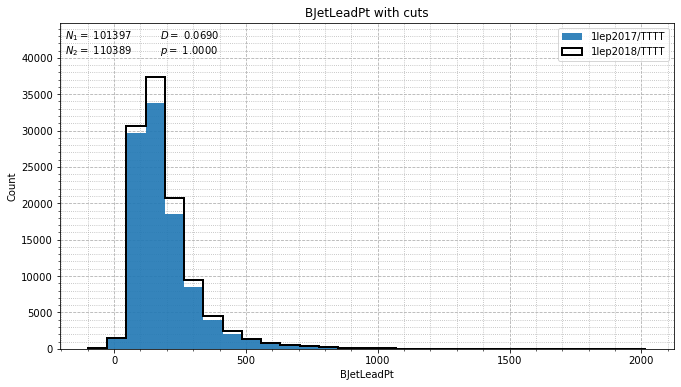

In [85]:
# set uniform binning
nBins = 30
minBin = min(min(branchCutOne),min(branchCutTwo))
maxBin = max(max(branchCutOne),max(branchCutTwo))
bins = np.linspace(minBin,maxBin,nBins).reshape(nBins)

# plot the histograms
plt.rc("axes", axisbelow = True)
plt.close()
plt.figure( figsize = (11, 6) )
plt.title( str(fileList.value) + " with cuts" )
histOne, binsOne, _ = plt.hist(
    branchCutOne,
    label = sampleDirOne.value.split("_")[1] + "/" + sampleOne.value.split("_TuneCP5")[0],
    histtype = "stepfilled",
    linewidth = 2,
    alpha = 0.9,
    bins = bins
)
histTwo, binsTwo, _ = plt.hist(
    branchCutTwo,
    label = sampleDirTwo.value.split("_")[1] + "/" + sampleTwo.value.split("_TuneCP5")[0],
    histtype = "step",
    linewidth = 2,
    color = "k",
    alpha = 1.0,
    bins = bins
)

D, pVal = stats.ks_2samp(histOne, histTwo)

plt.annotate(
    u"$N_1=$ {}".format( len( branchCutOne ) ),
    xycoords = "axes pixels",
    xy = (5,310)
)
plt.annotate(
    u"$N_2=$ {}".format( len( branchCutTwo ) ),
    xycoords = "axes pixels",
    xy = (5,295)
)
plt.annotate(
    u"$D=$ {:.4f}".format( D ),
    xycoords = "axes pixels",
    xy = (100,310)
)
plt.annotate(
    u"$p=$ {:.4f}".format( pVal ),
    xycoords = "axes pixels",
    xy = (100, 295)
)

plt.xlabel( str(fileList.value) )
plt.ylabel( "Count" )
plt.ylim(0,1.2*max(max(histOne),(max(histTwo))))
#plt.yscale( "log" )
plt.legend( loc = "best" )
plt.grid( which = "major", linestyle = "--" )
plt.grid( which = "minor", linestyle = ":")
plt.minorticks_on()
plt.show()